In [1]:
import numpy as np
import pandas as pd
import yfinance as yf
import scipy.stats as stats
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
start_date = '2014-01-01'
end_date = '2024-03-31'
usd_yuan_ticker = 'VNDUSD=X'
oil_ticker = 'CL=F'
raw_data = yf.download(tickers=[usd_yuan_ticker, oil_ticker], start=start_date, end=end_date)["Close"]
raw_data = raw_data.rename(columns={oil_ticker: "oil", usd_yuan_ticker: "currency"})
all_data = raw_data.copy(deep=True)

[*********************100%%**********************]  2 of 2 completed


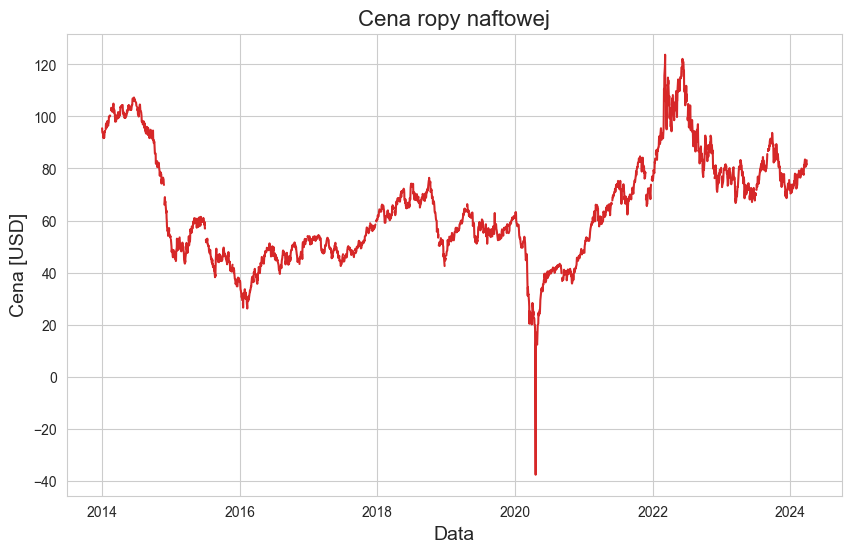

In [7]:
all_data.loc[all_data.oil < 0, "oil"] = np.nan

all_data = all_data.interpolate(method="linear")

In [21]:
all_data = all_data.pct_change(fill_method=None)

In [22]:
all_data['month'] = pd.PeriodIndex(all_data.index, freq='M')

monthly = all_data.groupby(by = 'month').max()

In [23]:
fit_m = monthly[:'2020-01']
test_m = monthly['2020-02':]

## Ropa

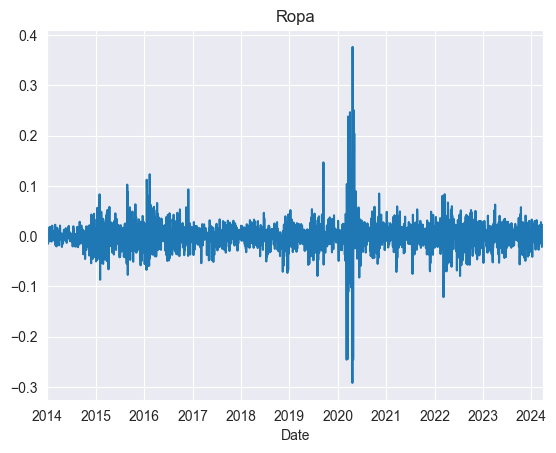

In [24]:
_ = all_data.oil.plot(title='Ropa')

In [25]:
c, loc, scale = stats.genextreme.fit(fit_m.oil)
print(f'c={c}, loc={loc}, scale={scale}')

c=-0.4123202971447911, loc=0.026968081528985575, scale=0.011106748453959453


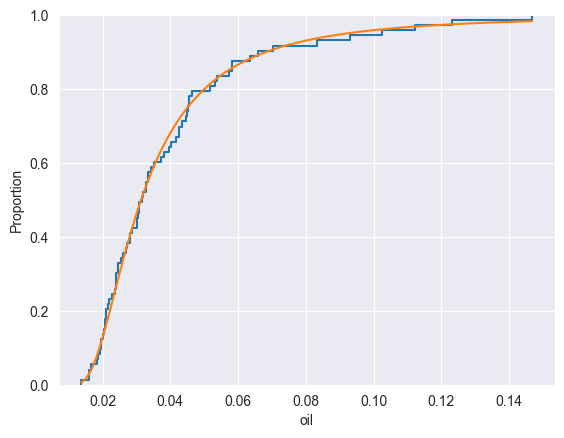

In [26]:
sns.ecdfplot(fit_m.oil)
t = np.linspace(min(fit_m.oil), max(fit_m.oil), 100)
_ = plt.plot(t, stats.genextreme.cdf(t, c, loc=loc, scale=scale))

## Backtesting

In [27]:
alpha_lower = 0.1
alpha_upper = 0.9

In [28]:
k = 10000
n = len(test_m)
a = stats.genextreme.rvs(c, loc, scale, k)
quantile_lower = np.quantile(a, alpha_lower)
quantile_upper = np.quantile(a, alpha_upper)

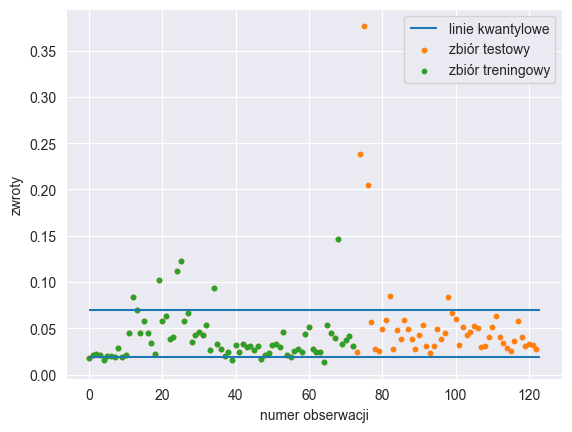

In [29]:
line1 = plt.hlines(quantile_lower, 0, len(monthly))
line2 = plt.hlines(quantile_upper, 0, len(monthly))
line3 = plt.scatter(range(len(monthly)), monthly.oil, s=10, c='C1')
line4 = plt.scatter(range(len(fit_m)), fit_m.oil, s=10, c='C2')
plt.legend([line1, line3, line4], ['linie kwantylowe', 'zbiór testowy', 'zbiór treningowy'])
plt.xlabel('numer obserwacji')
_ = plt.ylabel('zwroty')

In [30]:
'{}% zbioru testowego nie znajduje sie pomiędzy liniami kwantylowymi.'\
      .format(len(test_m.oil[(test_m.oil <= quantile_lower) | (test_m.oil >= quantile_upper)]) / len(test_m.oil) * 100)

'10.0% zbioru testowego nie znajduje sie pomiędzy liniami kwantylowymi.'

In [31]:
alpha_lower2 = 0.3
alpha_upper2 = 0.7

In [32]:
quantile_lower2 = np.quantile(a, alpha_lower2)
quantile_upper2 = np.quantile(a, alpha_upper2)

'54.0% zbioru testowego nie znajduje sie pomiędzy liniami kwantylowymi.'

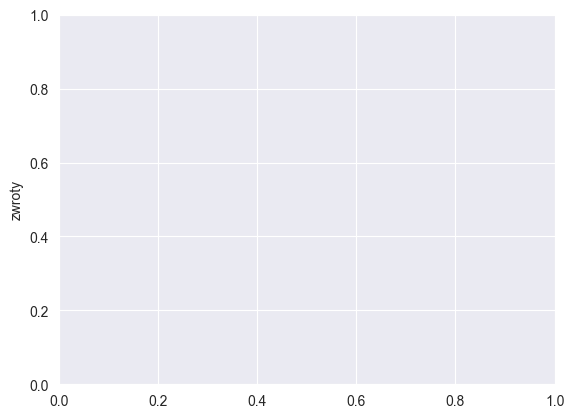

In [33]:
_ = plt.ylabel('zwroty')
'{}% zbioru testowego nie znajduje sie pomiędzy liniami kwantylowymi.' \
      .format(len(test_m.oil[(test_m.oil <= quantile_lower2) | (test_m.oil >= quantile_upper2)]) / len(test_m.oil) * 100)

# Na wszystkich danych

In [34]:
c, loc, scale = stats.genextreme.fit(monthly.oil)
print(f'c={c}, loc={loc}, scale={scale}')

c=-0.6150720499463997, loc=0.029683021745649886, scale=0.013955876764530487


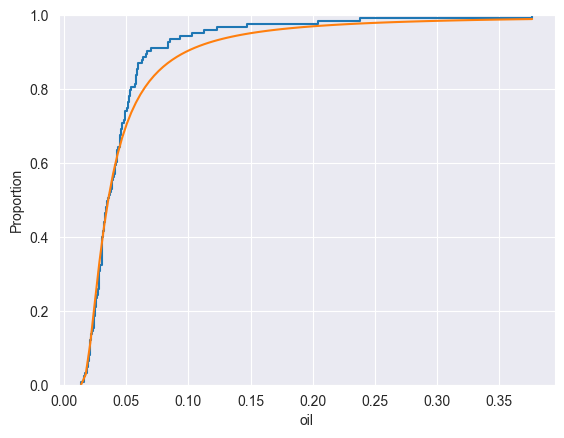

In [35]:
sns.ecdfplot(monthly.oil)
t = np.linspace(min(monthly.oil), max(monthly.oil), 100)
_ = plt.plot(t, stats.genextreme.cdf(t, c, loc=loc, scale=scale))

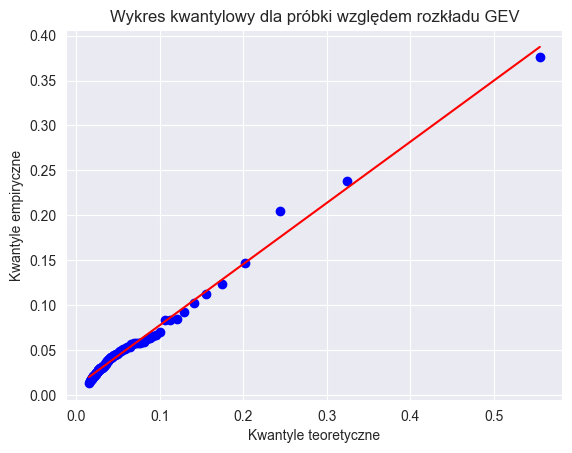

In [40]:
stats.probplot(monthly.oil, dist=stats.genextreme, sparams=(c,loc, scale), plot=plt)
plt.xlabel("Kwantyle teoretyczne")
plt.ylabel("Kwantyle empiryczne")
_ = plt.title("Wykres kwantylowy dla próbki względem rozkładu GEV")